# Process LevSeq

Here we want to join the LevSeq output data with the function data from the LCMS.

In [67]:
import pandas as pd
# get all the sequnence function files and see what those specific mutations did
# Also did any of the other mutations appear in the H2NOH files
import os
from copy import deepcopy
# Get them w.r.t to a mutation
from scipy.stats import mannwhitneyu
# get all the sequnence function files and see what those specific mutations did
# Also did any of the other mutations appear in the H2NOH files
import os
import numpy as np
from tqdm import tqdm
from sciutil import SciUtil

output_dir = 'output/'
fig_dir = 'figs/'

lineage_df = pd.read_csv('lineage_summary.tsv', sep='\t')
lineage_df['name'] = [f'{l}_{n}' for l, n in lineage_df[['linage', 'name']].values]
# Keep track of the parents for the LevSeq data
lineage_df['AA'] = [d.replace('*', '') for d in lineage_df['AA'].values]
parent_to_name = dict(zip(lineage_df.AA, lineage_df.name))
parents = list(set(lineage_df.AA.values))

In [68]:
lineage_df.to_csv(f'{output_dir}lineage_df.csv', index=False)

In [69]:


# Amino acid code conversion
AA_DICT = {
    "Ala": "A",
    "Cys": "C",
    "Asp": "D",
    "Glu": "E",
    "Phe": "F",
    "Gly": "G",
    "His": "H",
    "Ile": "I",
    "Lys": "K",
    "Leu": "L",
    "Met": "M",
    "Asn": "N",
    "Pro": "P",
    "Gln": "Q",
    "Arg": "R",
    "Ser": "S",
    "Thr": "T",
    "Val": "V",
    "Trp": "W",
    "Tyr": "Y",
    "Ter": "*",
}


def normalise_calculate_stats(processed_plate_df, value_column, normalise="standard", stats_method="mannwhitneyu", parent_label="#PARENT#", normalise_method="median", parent_to_name = None):
    # if nomrliase normalize with standard normalisation
    normalised_df = pd.DataFrame()
    all_stats_df = pd.DataFrame()
    processed_plate_df[value_column] = pd.to_numeric(processed_plate_df[value_column], errors='coerce')

    for plate in set(processed_plate_df["barcode_plate"].values):
        # Normalize for each value
        plate_parent = None
        plate_campaign = None
        sub_df = processed_plate_df[processed_plate_df["barcode_plate"] == plate].copy()
        parent_values = sub_df[sub_df["amino_acid_substitutions"] == parent_label][value_column].values
        if len(parent_values) == 0:
            u.err_p(['No parent!!! skipping plate... ', plate])
            continue
        else:
            plate_parent = sub_df[sub_df["amino_acid_substitutions"] == parent_label]['aa_sequence'].values[0]
            # By default use the median
            if normalise_method == "median":
                parent_mean = np.nanmedian(parent_values)
            else:
                parent_mean = np.nanmean(parent_values)
            parent_sd = np.nanstd(parent_values)
    
            # For each plate we normalise to the parent of that plate
            sub_df[f"{value_column} plate standard norm"] = (sub_df[value_column].values - parent_mean) / parent_sd
            sub_df[f"{value_column} fold change"] = sub_df[value_column].values/ parent_mean
            sub_df[f"{value_column} parent {normalise_method}"] = parent_mean
            sub_df[f"{value_column} parent SD"] = parent_sd

            norm_value_column = f"{value_column} plate standard norm"    
            sd_cutoff = 1.5  # The number of standard deviations we want above the parent values
            # Now for all the other mutations we want to look if they are significant, first we'll look at combinations and then individually
            grouped_by_mutations = sub_df.groupby("amino_acid_substitutions")
        
            rows = []
            for mutation, grp in grouped_by_mutations:
                # Get the values and then do a ranksum test
                if mutation != parent_label:
                    vals = list(grp[norm_value_column].values)
                    U1, p = None, None
                    # Now check if there are 3 otherwise we just do > X S.D over - won't be sig anyway.
                    if len(grp) > 2:
                        # Do stats
                        U1, p = mannwhitneyu(parent_values, vals, method="exact")
                    if normalise_method == "median":
                        mean_vals = np.nanmedian(vals)
                    else:
                        mean_vals = np.nanmean(vals)
                    std_vals = np.nanstd(vals)
                    median_vals = np.nanmedian(vals)
                    sig = mean_vals > ((sd_cutoff * parent_sd) + parent_mean)
                    rows.append([value_column, mutation, len(grp), mean_vals, std_vals, median_vals, (mean_vals - parent_mean)/parent_sd, sig, U1, p, plate_campaign, plate_parent, plate])
            stats_df = pd.DataFrame(rows, columns=["value_column",  "amino_acid_substitutions", "number of wells with amino_acid substitutions", "mean",
                    "std", "median", "standard normalized to parent mean", f"greater than > {sd_cutoff} parent", "man whitney U stat",
                    "p-value", 'campaign',  'parent', 'plate'],
                )
            all_stats_df = pd.concat([all_stats_df, stats_df])
            normalised_df = pd.concat([normalised_df, sub_df])

    return all_stats_df, normalised_df


def get_dist(seq1, seq2):
    seq1 = list(seq1)
    seq2 = list(seq2)
    dist = 0
    if len(seq1) != len(seq2):
        print(len(seq1), len(seq2), 'YIKES')
    for i in range(0, len(seq1)):
        if seq1[i] != seq2[i]:
            dist += 1
    #print(dist/len(seq1))
    return dist/len(seq1)



# Process the LevSeq data and combine with function data

In [70]:

u = SciUtil()

all_dfs = {}
all_stats_dfs = pd.DataFrame()
all_df = pd.DataFrame()

summary_rows = []
for base_dir in ['LCMS/NOPiv-linage_Done', 'LCMS/H2NOH-linage_Done',]:
    files = [f for f in os.listdir(base_dir) if '.csv' in f]
    for f in files:
        if f != '250714_HA-G7_step.csv':
            # Get all the sequence function files.
            run_name = f.replace('.csv', '')
            if os.path.exists(os.path.join(base_dir, run_name)):
                function_files = os.listdir(os.path.join(base_dir, run_name))
                
                all_function_df = pd.DataFrame()
                for function_file in function_files:
                    try:
                        # Barcode
                        barcode = function_file.split('.csv')[0].split('_')[-1]
                        function_df = pd.read_csv(f'{base_dir}/{run_name}/{function_file}', header=1)
                        # Now we want to line up the barcode with the file and then join on the wells
                        function_df['function_well'] = [x.split('-')[-1] if isinstance(x, str) else None for x in function_df['Sample Vial Number'].values]
                        function_df['function_barcode_plate'] = barcode
                        u.dp([f, set(function_df['Compound Name'].values)])
                        function_df = function_df[function_df['Compound Name'].isin(['Pdt', 'pdt'])] # We only use pdt or Pdt
                        # Convert it to numeric 
                        function_df['Area'] = pd.to_numeric(function_df['Area'], errors='coerce')
    
                        function_df['barcode_well'] = [f'{p}_{w}' for w, p in function_df[['function_well', 'function_barcode_plate']].values]
                        function_df['filename'] = function_file
                        all_function_df = pd.concat([all_function_df, function_df])
                    except:
                        print('fuction file', function_file)
                df = pd.read_csv(f'{base_dir}/{f}')
                
                df.columns = [c.lower() for c in df.columns]
                if 'barcode_plate' not in df.columns:
                    df = df.rename(columns={'protein sequence': 'aa_sequence'})
                    df['barcode_plate'] = df['plate'].values
    
                df['barcode_well'] = [f'{p}_{w}' for w, p in df[['well', 'barcode_plate']].values]
                # Join the two
                df.set_index('barcode_well', inplace=True)
                all_function_df.set_index('barcode_well', inplace=True)
                df = df.join(all_function_df, how='left')
                df.reset_index(inplace=True, drop=True)
                df['levSeq_filename'] = run_name
                df.columns = [c.replace(' ', '_') for c in df.columns]
                df = df[['barcode_plate',
                         'plate',
                         'nucleotide_mutation',
                         'amino_acid_substitutions',
                         'well', 
                         'average_mutation_frequency', 
                         'alignment_count',
                         'aa_sequence',
                         'Sample_Acq_Order_No', 'Sample_Vial_Number', 'Sample_Name',
                         'Compound_Name', 'RT_[min]', 'Area', 'function_well',
                         'function_barcode_plate', 'filename', 'levSeq_filename']]
                df = df.loc[:,~df.columns.duplicated()].copy()
                # Need to add in the fitness and the fitness_value	smiles_string
                df['fitness_value'] = df['Area'].values
                df['smiles_string'] = 'O=C(OC)C[C@H](N)C1=CC=CC=C1'
                # Get which parent it is
                min_dist = 1000
                generation_name = None
                # Will throw an error if there is no parent (but this is good because we don't want this then!)
                aa = df[df['amino_acid_substitutions'] == '#PARENT#']['aa_sequence'].values[0].replace('*', '')
                aa = aa.replace('*', '')
                # For the parent get the distance - some might have 1 or 2 aa's different... i.e. in stop codon
                for p in parents:
                    parent_dist = get_dist(p, aa)
                    if parent_dist < min_dist:
                        min_dist = parent_dist
                        generation_name = parent_to_name.get(p)
                        
                df['campaign_name'] = generation_name
                all_dfs[run_name] = df
    
                df = df.drop_duplicates(subset=['barcode_plate', 'well'])
                df = df.dropna(subset='Area')
                df = df.fillna(0)
                df.to_csv(f'{output_dir}/seqfunc/{generation_name}_{f}')
                stats_df, df = normalise_calculate_stats(df, 'Area',
                                normalise="standard",
                                stats_method="mannwhitneyu",
                                parent_label="#PARENT#",
                                normalise_method="mean",
                                parent_to_name = parent_to_name)
                stats_df['levSeq_filename'] = run_name
                all_df = pd.concat([all_df, df])
                all_stats_dfs =  pd.concat([all_stats_dfs, stats_df])
                u.warn_p(['Success!', run_name, generation_name, 'Distance between parent and generation:', min_dist, 
                         '\n # non zero fitness: ', len(df[df['fitness_value'] != 0]), '\n Size of dataset: ', len(df), 
                         '\n # unique sustitutions: ', len(set(df['amino_acid_substitutions'].values))])
    
                summary_rows.append([run_name, generation_name, min_dist, len(df[df['fitness_value'] != 0]), len(df), len(set(df['amino_acid_substitutions'].values))])
all_df



--------------------------------------------------------------------------------
                       20241115-JR-SSM-NOPiv.csv	{'Pdt'}	                       
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                       20241115-JR-SSM-NOPiv.csv	{'Pdt'}	                       
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                       20241115-JR-SSM-NOPiv.csv	{'Pdt'}	                       
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                       20241115-JR-SSM-NOPiv.csv	{'Pdt'}	                       
--------------------------------------------------------------------------------
----------------------------

/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_86883/1184702519.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_function_df = pd.concat([all_function_df, function_df])
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_86883/1184702519.py:84: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_86883/3947066311.py:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future 

--------------------------------------------------------------------------------
Success!	20240416-JR-SSM-NOPiv	NOPiv_G7-1	Distance between parent and generation:	0.0049261083743842365	
 # non zero fitness: 	558	
 Size of dataset: 	558	
 # unique sustitutions: 	108	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                      20240726-JR-epPCR-NOPiv.csv	{'Pdt'}	                      
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                      20240726-JR-epPCR-NOPiv.csv	{'Pdt'}	                      
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                      20240726-JR-epPCR-NOPiv.csv	{'Pdt'}	                      
----

/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_86883/3947066311.py:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_stats_df = pd.concat([all_stats_df, stats_df])


--------------------------------------------------------------------------------
                        20250319_SSM-H2NOH.csv	{'Pdt'}	                         
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                        20250319_SSM-H2NOH.csv	{'Pdt'}	                         
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Success!	20250319_SSM-H2NOH	H2NOH_G6	Distance between parent and generation:	0.0	
 # non zero fitness: 	433	
 Size of dataset: 	433	
 # unique sustitutions: 	99	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                       20240517-JR-SSM-H2NOH.csv	{'Pdt'}	                       
----------------------------

/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_86883/3947066311.py:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_stats_df = pd.concat([all_stats_df, stats_df])
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_86883/3947066311.py:52: RuntimeWarning: divide by zero encountered in divide
  sub_df[f"{value_column} plate standard norm"] = (sub_df[value_column].values - parent_mean) / parent_sd
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_86883/3947066311.py:52: RuntimeWarning: invalid value encountered in divide
  sub_df[f"{value_column} plate standard norm"] = (sub_df[value_column].values - parent_mean) / parent_sd
/Users/arianemora/miniconda3/envs/levseq/lib/python3.10/site-packages/numpy/_core/fromn

,barcode_plate,plate,nucleotide_mutation,amino_acid_substitutions,well,average_mutation_frequency,alignment_count,aa_sequence,Sample_Acq_Order_No,Sample_Vial_Number,...,function_barcode_plate,filename,levSeq_filename,fitness_value,smiles_string,campaign_name,Area plate standard norm,Area fold change,Area parent mean,Area parent SD
1,1,G12-2-M86C-W62X,A256T_T257G_G258T,#PARENT#,A2,0.916667,24.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,3.0,D4F-A2,...,1,JR-20241115-M86C_W62X_1.csv,20241115-JR-SSM-NOPiv,521668.1625,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,1.596803,1.088431,479284.402650,26542.882998
2,1,G12-2-M86C-W62X,T184G_G185A_A256T_T257G_G258T,W62E,A3,0.653333,15.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,4.0,D4F-A3,...,1,JR-20241115-M86C_W62X_1.csv,20241115-JR-SSM-NOPiv,431005.6363,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,-1.818897,0.899269,479284.402650,26542.882998
3,1,G12-2-M86C-W62X,T184A_G185A_G186T_A256T_T257G_G258T,W62N,A4,0.977778,15.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,5.0,D4F-A4,...,1,JR-20241115-M86C_W62X_1.csv,20241115-JR-SSM-NOPiv,130218.5864,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,-13.151014,0.271694,479284.402650,26542.882998
5,1,G12-2-M86C-W62X,T184G_G186T_A256T_T257G_G258T,#LOW#,A6,0.650000,8.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,6.0,D4F-A6,...,1,JR-20241115-M86C_W62X_1.csv,20241115-JR-SSM-NOPiv,37448.0135,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,-16.646134,0.078133,479284.402650,26542.882998
8,1,G12-2-M86C-W62X,T184G_G185T_G186T_A256T_T257G_G258T,W62V,A9,0.904255,47.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,7.0,D4F-A9,...,1,JR-20241115-M86C_W62X_1.csv,20241115-JR-SSM-NOPiv,91746.0809,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,-14.600461,0.191423,479284.402650,26542.882998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757,40,ep-P8,C202T_G499A,H68Y_V167I,H2,0.953901,141.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...,87,D6B-H2,...,40,20250403_HMC_epPCR_PA_P8_40.csv,20250404_epPCR-H2NOH,101166.8328,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G6-2,-6.591840,0.230890,438160.254575,51122.815929
762,40,ep-P8,T546C,#PARENT#,H7,0.946188,223.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...,92,D6B-H7,...,40,20250403_HMC_epPCR_PA_P8_40.csv,20250404_epPCR-H2NOH,462988.6023,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G6-2,0.485661,1.056665,438160.254575,51122.815929
763,40,ep-P8,T193C_T420A_T553A,S65P_W185R,H8,0.928205,65.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...,93,D6B-H8,...,40,20250403_HMC_epPCR_PA_P8_40.csv,20250404_epPCR-H2NOH,77850.9941,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G6-2,-7.047915,0.177677,438160.254575,51122.815929
764,40,ep-P8,#PARENT#,#PARENT#,H9,0.000000,283.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...,94,D6B-H9,...,40,20250403_HMC_epPCR_PA_P8_40.csv,20250404_epPCR-H2NOH,407279.0180,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G6-2,-0.604060,0.929521,438160.254575,51122.815929


In [71]:
summary_df = pd.DataFrame(summary_rows, columns=['run name', 'generation name', 'min-dist parent to generation', 'non-zero fitness', 'data size', '# unique substiutions'])
summary_df.to_csv(f'{output_dir}/LevSeq_CombinedDF_summary.csv', index=False)
summary_df

,run name,generation name,min-dist parent to generation,non-zero fitness,data size,# unique substiutions
0,20241115-JR-SSM-NOPiv,NOPiv_G13-2,0.000000,379,379,96
1,20240603-JR-SSM-NOPiv,NOPiv_G9-2,0.000000,234,234,68
2,20240404-JR-SSM-NOPiv-E1,NOPiv_G7-1,0.000000,283,283,68
3,20240404-JR-SSM-NOPiv-E2,NOPiv_G7-2,0.000000,277,277,75
4,20241106-JR-SSM-NOPiv,NOPiv_G10-2,0.000000,103,103,41
5,20240416-JR-SSM-NOPiv,NOPiv_G7-1,0.004926,558,558,108
6,20240726-JR-epPCR-NOPiv,NOPiv_G7-1,0.000000,364,364,119
7,20250122-JR-epPCR-H2NOH,H2NOH_G5,0.000000,266,266,51
8,20250215_SSM-H2NOH,H2NOH_G5,0.000000,288,288,97
9,20250227_StEP-H2NOH,H2NOH_G5,0.000000,191,191,60


# Make some summaries about the dataset

First check what campaigns are represented.

In [66]:
all_df.to_csv(f'{output_dir}LevSeq_CombinedDF_pdt_All.csv', index=False)

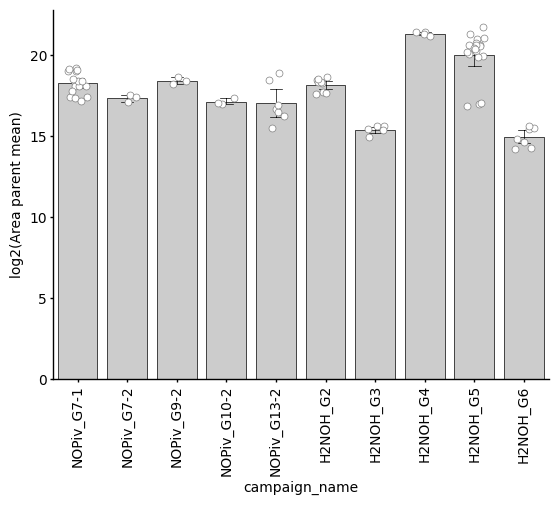

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

order = [ 'NOPiv_G7-1', 'NOPiv_G7-2', 'NOPiv_G9-2', 'NOPiv_G10-2','NOPiv_G13-2', 'H2NOH_G2', 'H2NOH_G3','H2NOH_G4', 'H2NOH_G5', 'H2NOH_G6']
plate_df = all_df.drop_duplicates(subset=['plate', 'Area parent mean'])
plate_df = plate_df.reset_index()

plate_df['log2(Area parent mean)'] = np.log2(plate_df['Area parent mean'].values + 1)

def clean_plt(ax):
    ax.tick_params(direction='out', length=2, width=1.0)
    ax.spines['bottom'].set_linewidth(1.0)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(1.0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(labelsize=10.0)
    ax.tick_params(axis='x', which='major', pad=2.0)
    plt.xticks(rotation=90)
    ax.tick_params(axis='y', which='major', pad=2.0)
    return ax
    
ax = sns.barplot(plate_df, x='campaign_name', y='log2(Area parent mean)', order=order,
                 err_kws={"color": 'black', "linewidth": 0.5},linewidth=0.5, edgecolor="black", capsize=.25, color='#cccc')
ax = sns.stripplot(plate_df, x='campaign_name', y='log2(Area parent mean)', ax=ax, jitter=0.2, c='white', edgecolor='grey', order=order, linewidth=0.5)

ax = clean_plt(ax)

In [6]:
# Remove any with no fitness data
all_df = all_df[~all_df['Area'].isna()]

# Remove non-0 fitnesses
all_df = all_df[all_df['fitness_value'] > 0.0]

all_df['campaign_name'].value_counts()

campaign_name
NOPiv_G7-1     1205
H2NOH_G5       1042
H2NOH_G2        794
H2NOH_G6-2      444
H2NOH_G6        433
NOPiv_G13-2     379
H2NOH_G4        375
H2NOH_G3        352
NOPiv_G7-2      277
NOPiv_G9-2      234
NOPiv_G10-2     103
Name: count, dtype: int64

# Look at what the parents were like over the plates

We expect these to correspond to the generations i.e. to be increasing with each one

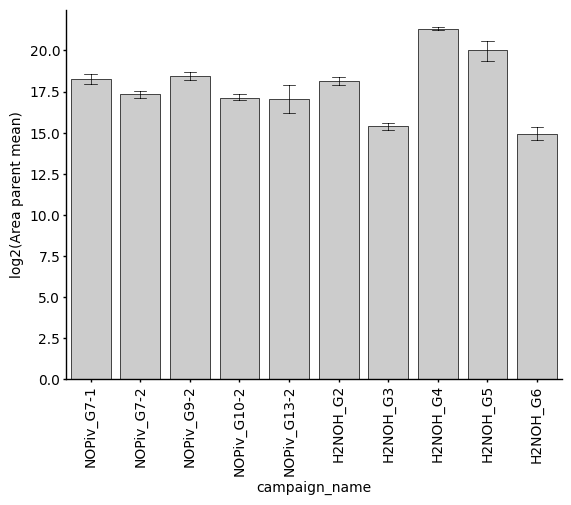

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

order = [ 'NOPiv_G7-1', 'NOPiv_G7-2', 'NOPiv_G9-2', 'NOPiv_G10-2','NOPiv_G13-2', 'H2NOH_G2', 'H2NOH_G3','H2NOH_G4', 'H2NOH_G5', 'H2NOH_G6']
plate_df = all_df.drop_duplicates(subset=['plate', 'Area parent mean'])
plate_df = plate_df.reset_index()

plate_df['log2(Area parent mean)'] = np.log2(plate_df['Area parent mean'].values + 1)

def clean_plt(ax):
    ax.tick_params(direction='out', length=2, width=1.0)
    ax.spines['bottom'].set_linewidth(1.0)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(1.0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(labelsize=10.0)
    ax.tick_params(axis='x', which='major', pad=2.0)
    plt.xticks(rotation=90)
    ax.tick_params(axis='y', which='major', pad=2.0)
    return ax
    
ax = sns.barplot(plate_df, x='campaign_name', y='log2(Area parent mean)', order=order, err_kws={"color": 'black', "linewidth": 0.5},linewidth=0.5, edgecolor="black", capsize=.25, color='#cccc')
ax = clean_plt(ax)

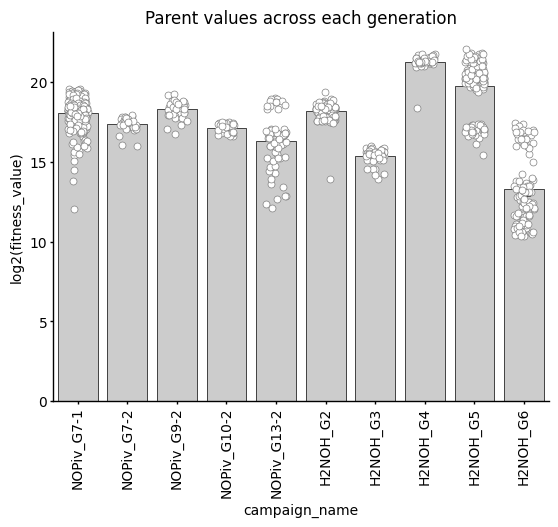

In [83]:
import seaborn as sns
plate_df = all_df[all_df['amino_acid_substitutions'] == '#PARENT#']
plate_df = plate_df.reset_index()
plate_df['log2(fitness_value)'] = np.log2(plate_df['fitness_value'].values + 1)


def clean_plt(ax):
    ax.tick_params(direction='out', length=2, width=1.0)
    ax.spines['bottom'].set_linewidth(1.0)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(1.0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(labelsize=10.0)
    ax.tick_params(axis='x', which='major', pad=2.0)
    plt.xticks(rotation=90)
    ax.tick_params(axis='y', which='major', pad=2.0)
    return ax
    
ax = sns.barplot(plate_df, x='campaign_name', y='log2(fitness_value)', order=order, err_kws={"color": 'black', "linewidth": 0.5},linewidth=0.5, edgecolor="black", capsize=.25, color='#cccc')
ax = sns.stripplot(plate_df, x='campaign_name', y='log2(fitness_value)', ax=ax, jitter=0.2, c='white', edgecolor='grey', order=order, linewidth=0.5)

ax = clean_plt(ax)
plt.title('Parent values across each generation')
plt.savefig('figs/parent_values.png', dpi=300, bbox_inches='tight')

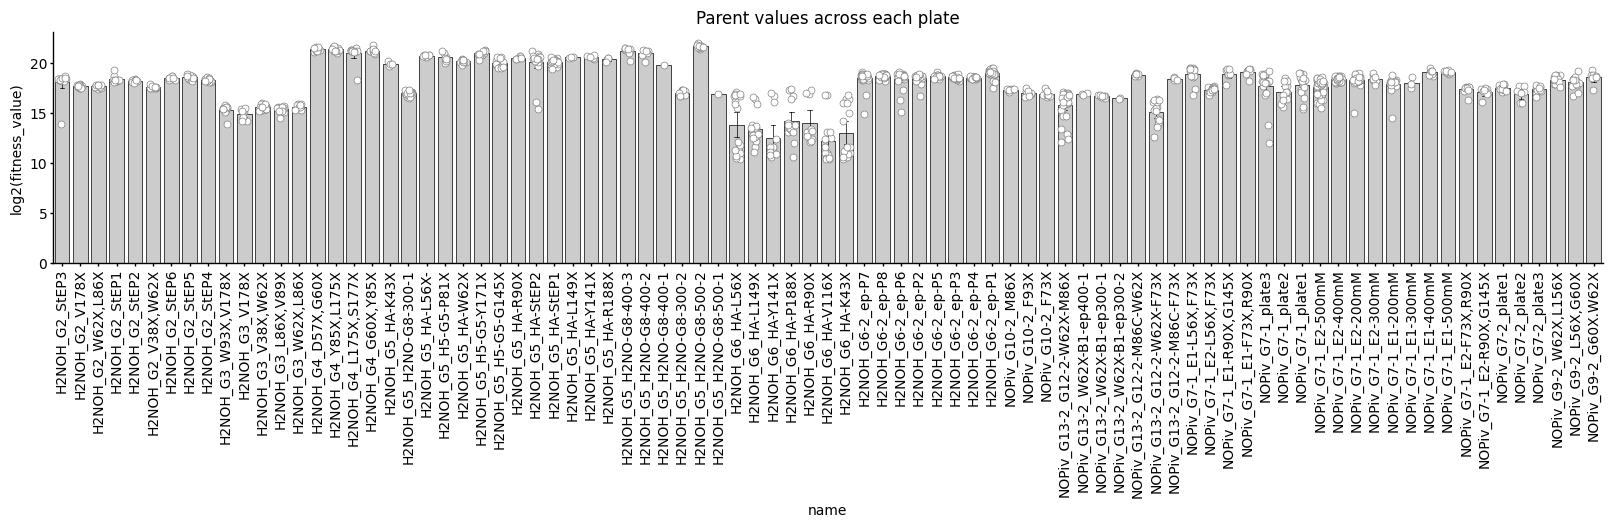

In [84]:
plate_df = plate_df.sort_values(by=['campaign_name'])
plt.figure(figsize=(20, 3))
plate_df['name'] = [f'{name}_{plate}' for name, plate in plate_df[['campaign_name', 'plate']].values]

ax = sns.barplot(plate_df, x='name', y='log2(fitness_value)', err_kws={"color": 'black', "linewidth": 0.5},linewidth=0.5, edgecolor="black", capsize=.25, color='#cccc')
ax = sns.stripplot(plate_df, x='name', y='log2(fitness_value)', ax=ax, jitter=0.2, c='white', edgecolor='grey', linewidth=0.5)
ax = clean_plt(ax)
plt.savefig(f'{fig_dir}normalized_parents_per_plate.svg')
plt.title('Parent values across each plate')
plt.savefig(f'{fig_dir}normalized_parents_per_plate.png', dpi=300, bbox_inches='tight')

# Filter for not-null values

In [85]:
# Next remove any values that we're not sure about i.e. low or NA in the sequenceing

nn_df = all_df[all_df['amino_acid_substitutions'] != '#N.A.#']
nn_df = nn_df[nn_df['amino_acid_substitutions'] != '#LOW#']
nn_df = nn_df[nn_df['amino_acid_substitutions'] != 'LEN']
nn_df = nn_df[nn_df['amino_acid_substitutions'] != '#PARENT#']

nn_df['amino_acid_substitutions'].value_counts()

amino_acid_substitutions
I149L                         60
L56V                          37
F73V                          26
L56K                          25
I146V                         23
                              ..
N75D_V89I_W93L_V127D_A134V     1
P138Q_I149L                    1
V89I_W93L_A134G_I149L          1
V38I_A59M_A91P_A134V_I149L     1
D10V                           1
Name: count, Length: 1106, dtype: int64

In [12]:
len(nn_df)

3603

In [13]:
nn_df = nn_df.drop_duplicates(subset=['nucleotide_mutation', 'fitness_value'])
nn_df

,barcode_plate,plate,nucleotide_mutation,amino_acid_substitutions,well,average_mutation_frequency,alignment_count,aa_sequence,Sample_Acq_Order_No,Sample_Vial_Number,...,function_barcode_plate,filename,levSeq_filename,fitness_value,smiles_string,campaign_name,Area plate standard norm,Area fold change,Area parent mean,Area parent SD
2,1,G12-2-M86C-W62X,T184G_G185A_A256T_T257G_G258T,W62E,A3,0.653333,15.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,4.0,D4F-A3,...,1,JR-20241115-M86C_W62X_1.csv,20241115-JR-SSM-NOPiv,431005.6363,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,-1.818897,0.899269,479284.402650,26542.882998
3,1,G12-2-M86C-W62X,T184A_G185A_G186T_A256T_T257G_G258T,W62N,A4,0.977778,15.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,5.0,D4F-A4,...,1,JR-20241115-M86C_W62X_1.csv,20241115-JR-SSM-NOPiv,130218.5864,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,-13.151014,0.271694,479284.402650,26542.882998
8,1,G12-2-M86C-W62X,T184G_G185T_G186T_A256T_T257G_G258T,W62V,A9,0.904255,47.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,7.0,D4F-A9,...,1,JR-20241115-M86C_W62X_1.csv,20241115-JR-SSM-NOPiv,91746.0809,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,-14.600461,0.191423,479284.402650,26542.882998
9,1,G12-2-M86C-W62X,T184A_G186T_A256T_T257G_G258T,W62S,A10,0.964103,39.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,8.0,D4F-A10,...,1,JR-20241115-M86C_W62X_1.csv,20241115-JR-SSM-NOPiv,100422.7253,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,-14.273569,0.209526,479284.402650,26542.882998
10,1,G12-2-M86C-W62X,T184G_G185T_A256T_T257G_G258T,W62V,A11,0.937931,29.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,9.0,D4F-A11,...,1,JR-20241115-M86C_W62X_1.csv,20241115-JR-SSM-NOPiv,80172.7978,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,-15.036483,0.167276,479284.402650,26542.882998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,40,ep-P8,C5T,T2I,G4,0.846154,78.0,MIPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...,77,D6B-G4,...,40,20250403_HMC_epPCR_PA_P8_40.csv,20250404_epPCR-H2NOH,331518.9205,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G6-2,-2.085983,0.756616,438160.254575,51122.815929
748,40,ep-P8,C488T,S163L,G5,0.960000,75.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...,78,D6B-G5,...,40,20250403_HMC_epPCR_PA_P8_40.csv,20250404_epPCR-H2NOH,291902.5909,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G6-2,-2.860908,0.666201,438160.254575,51122.815929
757,40,ep-P8,C202T_G499A,H68Y_V167I,H2,0.953901,141.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...,87,D6B-H2,...,40,20250403_HMC_epPCR_PA_P8_40.csv,20250404_epPCR-H2NOH,101166.8328,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G6-2,-6.591840,0.230890,438160.254575,51122.815929
763,40,ep-P8,T193C_T420A_T553A,S65P_W185R,H8,0.928205,65.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...,93,D6B-H8,...,40,20250403_HMC_epPCR_PA_P8_40.csv,20250404_epPCR-H2NOH,77850.9941,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G6-2,-7.047915,0.177677,438160.254575,51122.815929


# Check which positions were mutated across the campaign

In [14]:
# Now we want the actual number of positions we can do this by computing all numbers
from collections import defaultdict
positions = []
position_dict = defaultdict(list)
position_to_value = defaultdict(dict)
for subs, value in nn_df[['amino_acid_substitutions', 'Area plate standard norm']].values:
    for pos in subs.split('_'):
        # Only keep those that weren't retained
        positions.append(int(pos[1:-1]))
        position_dict[int(pos[1:-1])].append(pos[-1])
        if position_to_value[int(pos[1:-1])].get(pos[-1]):
            value = float(value)
            position_to_value[int(pos[1:-1])][pos[-1]].append(value)
        else:
            position_to_value[int(pos[1:-1])][pos[-1]] = []
            value = float(value)
            position_to_value[int(pos[1:-1])][pos[-1]].append(value)
print(len(set(positions)))

190


# Check whether there are too many substitutions

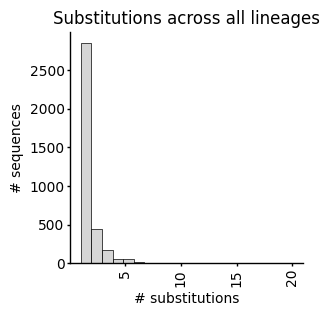

In [90]:
import matplotlib.pyplot as plt
nn_df['# substitutions'] = [len(x.split('_')) for x in nn_df['amino_acid_substitutions'].values]
plt.figure(figsize=(3, 3))
plt.hist(nn_df['# substitutions'].values, bins=20, color='#cccc', linewidth=0.5, edgecolor='black')
plt.title('Substitutions across all lineages')
plt.xlabel('# substitutions')
plt.ylabel('# sequences')

clean_plt(plt.gca())
plt.savefig('figs/number_subs.png', dpi=300, bbox_inches='tight')

In [16]:
many_subs = nn_df[nn_df['# substitutions'] > 10]
many_subs # Great these just look like it's from StEP which is expected

,barcode_plate,plate,nucleotide_mutation,amino_acid_substitutions,well,average_mutation_frequency,alignment_count,aa_sequence,Sample_Acq_Order_No,Sample_Vial_Number,...,filename,levSeq_filename,fitness_value,smiles_string,campaign_name,Area plate standard norm,Area fold change,Area parent mean,Area parent SD,# substitutions
36,18,HA-K43X,G24A_A39T_C66T_T86A_T93C_G99A_G106A_G133T_C134...,M29K_E36K_A45C_M59Y_R61G_V63A_F86L_W93F_V97I_A...,D1,0.551282,14.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEKDVMYLKKACD...,22.0,D3F-D1,...,JR-20250215-HA-K43X_achiral_18.csv,20250215_SSM-H2NOH,8.088097e+05,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G5,-1.511273,0.791814,1.021464e+06,140711.863893,18
756,25,HA-R188X,G24A_A39T_C66T_T86A_T93C_G99A_G106A_G133T_C134...,M29K_E36K_A45C_M59Y_G60P_R61G_V63A_F86L_W93F_V...,H1,0.823129,14.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEKDVMYLKKACD...,39.0,D6B-H1,...,JR-20250215-HA-P188X_achiral_25.csv,20250215_SSM-H2NOH,5.502202e+04,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G5,-10.307463,0.039487,1.393432e+06,129848.619632,20
30,37,HA-StEP1,C19T_A39T_C66T_T86A_T93C_T95C_G99A_C135T_C181G...,P7S_M29K_M32T_R61G_V63A_F73G_E80A_F86L_W93I_V9...,C7,0.776442,13.0,MTPSDISGYDYGRVEKSPITDLEFDLLKKTVTLGEEDVMYLKKAAD...,32.0,D3F-C7,...,JR-20250227-step1_37.csv,20250227_StEP-H2NOH,7.683532e+04,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G5,-5.512855,0.065423,1.174435e+06,199098.198828,17
84,37,HA-StEP1,C19T_A39T_C66T_T86A_T93C_T95C_G99A_C135T_C181G...,P7S_M29K_M32T_R61G_V63A_F73G_E80A_F86L_W93I_V9...,H1,0.783838,30.0,MTPSDISGYDYGRVEKSPITDLEFDLLKKTVTLGEEDVMYLKKAAD...,86.0,D3F-H1,...,JR-20250227-step1_37.csv,20250227_StEP-H2NOH,4.894387e+04,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G5,-5.652944,0.041674,1.174435e+06,199098.198828,18
96,38,HA-StEP2,C19T_A39T_C66T_T86A_T93C_T95C_G99A_C135T_C181G...,P7S_M29K_M32T_R61G_V63A_F73G_E80A_F86L_W93I_V9...,A1,0.820707,12.0,MTPSDISGYDYGRVEKSPITDLEFDLLKKTVTLGEEDVMYLKKAAD...,2.0,D3B-A1,...,JR-20250227-step2_38.csv,20250227_StEP-H2NOH,5.802637e+04,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G5,-2.738083,0.042344,1.370348e+06,479284.919555,18
120,38,HA-StEP2,C19T_G38A_A39T_C66T_T86A_T93C_G99A_C135T_C181G...,P7S_R13H_M29K_R61G_V63L_E80A_F86L_W93C_G94V_A1...,C1,0.843094,181.0,MTPSDISGYDYGHVEKSPITDLEFDLLKKTVMLGEEDVMYLKKAAD...,26.0,D3B-C1,...,JR-20250227-step2_38.csv,20250227_StEP-H2NOH,5.384710e+04,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G5,-2.746803,0.039294,1.370348e+06,479284.919555,18
122,38,HA-StEP2,C19T_G38A_A39T_C66T_T86A_T93C_G99A_C135T_C181G...,P7S_R13H_M29K_R61G_V63L_E80A_F86L_W93C_G94V_A1...,C3,0.613596,76.0,MTPSDISGYDYGHVEKSPITDLEFDLLKKTVMLGEEDVMYLKKAAD...,28.0,D3B-C3,...,JR-20250227-step2_38.csv,20250227_StEP-H2NOH,2.137870e+06,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G5,1.601389,1.560092,1.370348e+06,479284.919555,18
133,38,HA-StEP2,A39T_C66T_T86A_T93C_G99A_A107G_G112A_A114G_A12...,M29K_E36G_V38M_K43M_M59V_R61G_F86C_V89I_W93I_V...,D2,0.807983,103.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEGDMMYLKMAAD...,39.0,D3B-D2,...,JR-20250227-step2_38.csv,20250227_StEP-H2NOH,5.919527e+04,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G5,-2.735644,0.043197,1.370348e+06,479284.919555,13


# Save these dataframes

In [17]:
all_df.to_csv(f'{output_dir}/LevSeq_CombinedDF_pdt.csv', index=False)
nn_df.to_csv(f'{output_dir}/LevSeq_CombinedDF_pdt_filtered.csv', index=False)

# Deduplicate variants to run folding on

In [18]:
nn_df = nn_df.sort_values(by='Area fold change', ascending=False)
len(set(nn_df['aa_sequence'].values)) # Have a look at all the unique proteins

1549

In [19]:
nn_df

,barcode_plate,plate,nucleotide_mutation,amino_acid_substitutions,well,average_mutation_frequency,alignment_count,aa_sequence,Sample_Acq_Order_No,Sample_Vial_Number,...,filename,levSeq_filename,fitness_value,smiles_string,campaign_name,Area plate standard norm,Area fold change,Area parent mean,Area parent SD,# substitutions
348,37,HA-V116X,G346T_T347G,V116C,F1,0.656805,169.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...,62,D4B-F1,...,250319-JR-HA-V116X_37.csv,20250319_SSM-H2NOH,1.960611e+05,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G6,4.592306,10.154939,19306.970371,38489.192714,1
357,37,HA-V116X,G346A_T348G,V116M,F10,0.618557,97.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...,71,D4B-F10,...,250319-JR-HA-V116X_37.csv,20250319_SSM-H2NOH,1.344859e+05,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G6,2.992501,6.965666,19306.970371,38489.192714,1
203,36,HA-Y141X,T421C_A422T,Y141L,A12,0.519231,78.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...,13,D5F-A12,...,250319-JR-HA-Y141X_36.csv,20250319_SSM-H2NOH,1.546667e+05,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G6,2.944981,5.989645,25822.354831,43750.491107,1
636,40,HA-K43X,A128T,K43M,F1,0.673469,147.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKMAAD...,62,D3F-F1,...,250319-JR-HA-K43X_40.csv,20250319_SSM-H2NOH,1.451132e+05,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G6,2.992145,4.922759,29478.025135,38646.252733,1
225,8,StEP3,T367C_G393A_C401T_A445C_C447T,S123P_A134V_I149L,C10,0.875000,48.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDVMYLKKAAD...,35,D4F-C10,...,StEP3_8.csv,20240504-JR-StEP-H2NOH,1.480802e+06,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G2,13.053814,4.494540,329466.983807,88199.160911,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,9,"E1-R90X,G145X",G433C_G434T_T435G_C445A_T447C,G145L_L149I,H4,0.979323,532.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,283.0,D6F-H4,...,JR-20240416-E1-R90XG145X_9.csv,20240416-JR-SSM-NOPiv,1.901427e+03,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G7-1,-3.587298,0.003586,530258.404250,147285.513073,2
255,9,"E1-R90X,G145X",G433C_G434A_T435G_C445A_T447C,G145Q_L149I,F4,0.960618,518.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,259.0,D6F-F4,...,JR-20240416-E1-R90XG145X_9.csv,20240416-JR-SSM-NOPiv,1.810222e+03,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G7-1,-3.587917,0.003414,530258.404250,147285.513073,2
127,6,"E1-F73X,R90X",T217G_T218A_C219G,F73E,C8,0.930199,234.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,130.0,D5B-C8,...,JR-20240416-E1-F73XR90X_6.csv,20240416-JR-SSM-NOPiv,1.668849e+03,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G7-1,-5.222858,0.002794,597394.948530,114061.314675,1
268,9,"E1-R90X,G145X",G433T_G434T_C445A_T447C,G145F_L149I,G5,0.971654,635.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,272.0,D6F-G5,...,JR-20240416-E1-R90XG145X_9.csv,20240416-JR-SSM-NOPiv,1.313169e+03,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G7-1,-3.591292,0.002476,530258.404250,147285.513073,2


In [20]:
nn_df['aa_sequence'] = [a.replace('*', '') for a in nn_df['aa_sequence'].values]
nn_df['name'] = [f'{c}_{i}' for i, c in enumerate(nn_df['campaign_name'].values)]
# Keep the highest fitness variant
nn_df = nn_df.sort_values(by='Area plate standard norm', ascending=False)
dedup = nn_df.drop_duplicates(subset=['aa_sequence'], keep='first')
for seq in dedup['aa_sequence'].values:
    if 'LEHHHHHH' not in seq:
        print(seq)

MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAADVLKDQVDEILDLAGGWVASNEHLIYYFSNPDTGEPIKEYLERIRPRWGAWVLDTTCRDYNREWLDYQYEVGLRHHRSKKGVTDGVRTVPNTPLRYLIAGIYPLTATIKPLLAEKGGSPEDIEGMYNAWLKSVVLQVAIWSHPYTKENDWPEHHHHHH
MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAADVLKDQVDEITDLVGGVVASNEHLIYYFSNPDTGEPIKEYMERITARFGAWVQDTTCRDYNREWLDYQYEVGLRHHRSKKGVTDGVRTVPNTPLRYLIAGIYPLTATIKPLLAEKGGSPEDIEGMYNAWLKSMVLQVAIWSHPYTKENDWPEHHHHHH
MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAADVLKDQVDEIIDLMGRWVASNEHLIYYFSNPDTGEPIKEYFERVRARWGAWVLDTTCRDYNREWLDYQYEVGLRHHRSKKGVTDGVRTAPNTPLRYLIAGIYPLTATIKPLLAEKGGSPEDVEGMYNALLKSVVLQVAIWSHPYTKENDWFEHHHHHH
MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVVYLKKAADVLKDQVDEILDLMGRYVASNEHLIYYFSNPDTGEPIKEYFERVRARWGAWVLDTTCRDYNREWLDYQYERGLRHHRSKKGVTDGVRTAPNTPLRYLIAGIYPLTATIKPLLAEKGGSPEDVEGMYNALLKSVVLQVAIWSHPYTKENDWPEHHHHHH
MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAADVLKDQVDEITDLVGGWVASNEHLIYYFSNPDTGEPIKEYMERITARFGAWVLDTTCRDYNREWLDYQYEVGLRHHRSKKGVTDGVRTVPNTPLRYLIAGIYPLTATIKPLLAEKGGSPEDIEGMYNAWLKSMVLQVAI

In [24]:
dedup.to_csv(f'{output_dir}/LevSeq_unique_variants.csv', index=False)

In [20]:
dedup

,barcode_plate,plate,nucleotide_mutation,amino_acid_substitutions,well,average_mutation_frequency,alignment_count,aa_sequence,Sample_Acq_Order_No,Sample_Vial_Number,...,levSeq_filename,fitness_value,smiles_string,campaign_name,Area plate standard norm,Area fold change,Area parent mean,Area parent SD,# substitutions,name
662,7,W62X-B1-ep400-1,C5T_G351A,T2I,H2,0.946154,65.0,MIPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,47.0,D6F-H2,...,20241115-JR-SSM-NOPiv,166001.1649,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,4.481096,15.906161,10436.281067,34715.811231,1,NOPiv_G13-2_0
614,7,W62X-B1-ep400-1,A476T,E159V,D2,0.863636,44.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,24.0,D6F-D2,...,20241115-JR-SSM-NOPiv,143375.3197,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,3.829351,13.738162,10436.281067,34715.811231,1,NOPiv_G13-2_2
628,7,W62X-B1-ep400-1,C5A_A137G,T2N_D46G,E4,0.968750,48.0,MNPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAG...,32.0,D6F-E4,...,20241115-JR-SSM-NOPiv,136333.4536,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,3.626508,13.063413,10436.281067,34715.811231,2,NOPiv_G13-2_3
670,7,W62X-B1-ep400-1,T293A_T587C,L98Q_L196P,H10,0.893333,75.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,51.0,D6F-H10,...,20241115-JR-SSM-NOPiv,134513.5389,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,3.574085,12.889030,10436.281067,34715.811231,2,NOPiv_G13-2_4
594,7,W62X-B1-ep400-1,C491A,P164Q,B6,0.757576,33.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,11.0,D6F-B6,...,20241115-JR-SSM-NOPiv,134409.0850,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,3.571076,12.879021,10436.281067,34715.811231,1,NOPiv_G13-2_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,9,"E1-R90X,G145X",G433A_G434T_T435G,G145M,G4,0.967101,922.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,271.0,D6F-G4,...,20240416-JR-SSM-NOPiv,2217.5938,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G7-1,-3.585151,0.004182,530258.404250,147285.513073,1,NOPiv_G7-1_3590
127,2,G12-2-M86C-F73X,T218A_C219T_A256T_T257G_G258T,F73Y,C8,0.900000,14.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,33.0,D4B-C8,...,20241115-JR-SSM-NOPiv,1496.2454,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,-13.204859,0.004176,358323.888800,27022.451103,1,NOPiv_G13-2_3591
241,9,"E1-R90X,G145X",G433T_G434T_C445A_T447C_A512G,G145F_L149I_Y171C,E2,0.959477,153.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,245.0,D6F-E2,...,20240416-JR-SSM-NOPiv,2112.9614,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G7-1,-3.585861,0.003985,530258.404250,147285.513073,3,NOPiv_G7-1_3593
186,2,G12-2-M86C-F73X,T217G_T218A_C219G_A256T_T257G_G258T,F73E,H7,0.926667,25.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,92.0,D4B-H7,...,20241115-JR-SSM-NOPiv,1377.0139,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,-13.209271,0.003843,358323.888800,27022.451103,1,NOPiv_G13-2_3594


# Run folding with the substrate and intermediate

```
import sys
from enzymetk.dock_boltz_step import Boltz
from enzymetk.save_step import Save
import pandas as pd
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'

output_dir = 'boltz_26062025'
num_threads = 5
id_col = 'name'
seq_col = 'aa_sequence'
substrate_col = 'Substrate'
intermediate_col = 'Intermediate'
df = pd.read_csv('../output/LevSeq_unique_variants.csv')
df[substrate_col] = "O=C(OC)CCC1=CC=CC=C1"
df[intermediate_col] = str(r"CC1=C(/C2=C/C3=N/C(C(C)=C3CCC(O)=O)=C\C4=C(C(C=C)=C(/C=C5N=C(C(C=C)=C\5C)/C=C1\N26)N4[Fe]6=N)C)CCC(O)=O")

df << (Boltz(id_col, seq_col, substrate_col, intermediate_col, f'{output_dir}', num_threads) >> Save(f'{output_dir}filenames.pkl'))

```